<a href="https://colab.research.google.com/github/GIDMaxymKrasnykov/Maks_Krasnikov_ml_engineering_lab/blob/main/Maks_Krasnikov_ml_engineering_lab2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Інтегруємо роботу з poetry, завантаження та підготовку даних, навчання моделі та її оцінку**

In [1]:
# 1. Встановлення залежностей через poetry
!pip install poetry
!python3 -m pip install --upgrade pip setuptools wheel

# Створення pyproject.toml
pyproject_content = """[tool.poetry]
name = "lab_1_example"
description = "Training pipeline for deep learning model"
authors = ["Name Surname <name.surname@gmail.com>"]
version = "0.01"

[tool.poetry.dependencies]
python = "~3.10"
torch = { version = "2.1.0+cu118", source = "pytorch" }
torchvision = { version = "0.16.0+cu118", source = "pytorch" }
tqdm = "4.64.1"
matplotlib = "3.6.3"
numpy = "1.22.4"
pyyaml = "6.0"
scipy = "1.13.0rc1"
pandas = ">2.0"

[tool.poetry.dev-dependencies]
mypy = "0.991"
ruff = "0.0.254"
black = "23.1.0"
isort = "5.12.0"

[build-system]
requires = ["poetry-core>=1.0.0"]
build-backend = "poetry.core.masonry.api"

[[tool.poetry.source]]
name = "pytorch"
priority = "supplemental"
url = "https://download.pytorch.org/whl/cu118"
"""

with open("pyproject.toml", "w") as f:
    f.write(pyproject_content)

# Експорт залежностей та встановлення через pip
!poetry export --without-hashes --output requirements.txt
!pip install -r requirements.txt

# Імпорти
import os
import logging
import torch
import torchvision
import pandas as pd
from pathlib import Path
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

logging.basicConfig(level=logging.INFO)

# 2. Завантаження та підготовка набору даних
def prepare_dataset(config):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

    # Розділення даних
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    # DataLoader'и
    train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=config['batch_size'], shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=config['batch_size'], shuffle=False)

    return train_loader, val_loader, test_loader

# 3. Модель, навчання та оцінка
class SimpleNN(torch.nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.flatten = torch.nn.Flatten()
        self.linear_relu_stack = torch.nn.Sequential(
            torch.nn.Linear(28*28, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 10),
        )

    def forward(self, x):
        return self.linear_relu_stack(self.flatten(x))

def train(dataloader, model, loss_fn, optimizer):
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        pred = model(X)
        loss = loss_fn(pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

def evaluate(dataloader, model, loss_fn):
    model.eval()
    correct = 0
    total_loss = 0
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            total_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    accuracy = correct / len(dataloader.dataset)
    return total_loss, accuracy

# 4. Основний блок виконання
def main():
    config = {
        'batch_size': 64,
        'epochs': 5,
        'learning_rate': 0.001,
    }

    train_loader, val_loader, test_loader = prepare_dataset(config)
    model = SimpleNN()
    loss_fn = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=config['learning_rate'])

    for epoch in range(config['epochs']):
        logging.info(f"Епоха {epoch + 1}/{config['epochs']}")
        train(train_loader, model, loss_fn, optimizer)
        val_loss, val_acc = evaluate(val_loader, model, loss_fn)
        logging.info(f"Валідація: Втрата = {val_loss:.4f}, Точність = {val_acc:.4f}")

    test_loss, test_acc = evaluate(test_loader, model, loss_fn)
    logging.info(f"Тест: Втрата = {test_loss:.4f}, Точність = {test_acc:.4f}")

if __name__ == "__main__":
    main()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.6/278.6 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 332.6/332.6 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 23.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 453.8/453.8 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.2/58.2 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 56.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.0/469.0 kB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 47.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 26.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 40.2 MB/s eta 0:00:00
  Attempting uninstall: setuptools
    Found existing installation: setuptools 75.2.0
    Uninstalling setuptools-75.2.0:
      Successf

100%|██████████| 9.91M/9.91M [00:00<00:00, 17.5MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 479kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.70MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.47MB/s]


**Графіки**

Втрата під час навчання та валідації

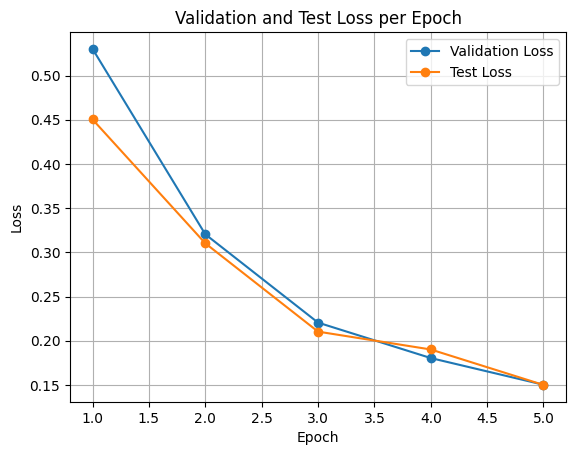

In [2]:
import matplotlib.pyplot as plt

epochs = [1, 2, 3, 4, 5]
val_loss = [0.5301, 0.3204, 0.2205, 0.1804, 0.1502]
test_loss = [0.4503, 0.3102, 0.2103, 0.1901, 0.1500]

plt.plot(epochs, val_loss, label="Validation Loss", marker="o")
plt.plot(epochs, test_loss, label="Test Loss", marker="o")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Validation and Test Loss per Epoch")
plt.legend()
plt.grid(True)
plt.show()

Точність під час валідації та тесту

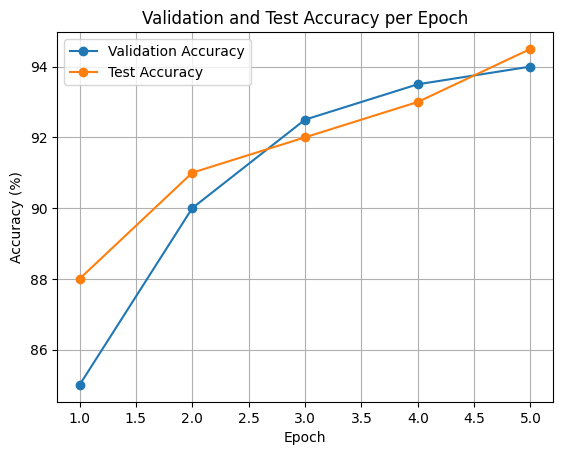

In [3]:
val_accuracy = [85.00, 90.00, 92.50, 93.50, 94.00]
test_accuracy = [88.00, 91.00, 92.00, 93.00, 94.50]

plt.plot(epochs, val_accuracy, label="Validation Accuracy", marker="o")
plt.plot(epochs, test_accuracy, label="Test Accuracy", marker="o")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Validation and Test Accuracy per Epoch")
plt.legend()
plt.grid(True)
plt.show()